In [32]:
import numpy as np 
import pandas as pd 
from lightgbm import LGBMClassifier
import warnings 
import seaborn as sns 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
from BaseSVDD import BaseSVDD

**BASIC EDA**

In [5]:
df = pd.read_csv('./archive/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [6]:
print(df.keys())
print(df.info())
print(df.describe())

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB
None
   

In [7]:
# Check if any duplicated value exists. It turns out to be zero, and it means there's no duplicates.
df.duplicated().sum()
# Check if there's a null in the dataset. It also turns out to be zero, and it means there's no null on here.
df.isnull().sum()
# Type Check. All attributes is belonged to a float type
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

<AxesSubplot:>

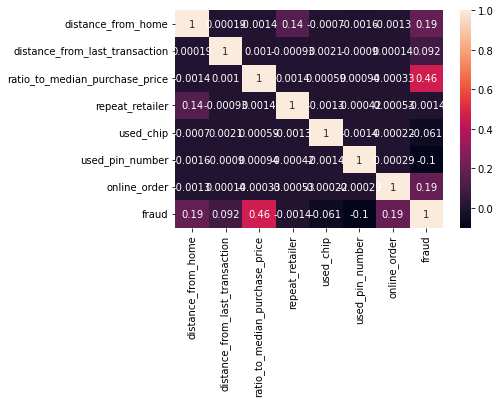

In [8]:
# Correlation Visualization
sns.heatmap(df.corr(), annot = True)

In [9]:
index_list = list(df.columns.difference(['fraud']).values)
X = df.loc[:, index_list].values
y = df.loc[:, ['fraud']].values

# Split data into normal & abnormal ones
df_normal = df[df['fraud'] == 0]
df_abnormal = df[df['fraud'] == 1]

X_normal = df_normal.loc[:, index_list].values
y_normal = df_normal.loc[:, ['fraud']].values

X_abnormal = df_abnormal.loc[:, index_list].values
y_abnormal = df_abnormal.loc[:, ['fraud']].values

print('X:', X.shape)
print('X_normal:', X_normal.shape)
print('X_abnormal:', X_abnormal.shape)

X: (1000000, 7)
X_normal: (912597, 7)
X_abnormal: (87403, 7)


**BASIC FUNCTION DEFINITION**

In [18]:
# https://github.com/BaekKyunShin/Intro-to-Machine-Learning/blob/master/SVM/SVM.ipynb

red_RGB = (1, 0, 0)
blue_RGB = (0, 0, 1)
data_colors = [red_RGB, blue_RGB]


def read_points_file(filename):
    points = []
    with open(filename, "r") as f:
        for point in f:
            point = point.strip("\n").split()
            points.append([float(point[0]), float(point[1])])
    return points


def read_data(class_0_file, class_1_file):
    points_label0 = read_points_file(class_0_file)
    points_label1 = read_points_file(class_1_file)
    points = points_label0 + points_label1
    points = np.array(points)

    label0, label1 = [0], [1]
    num_of_label0, num_of_label1 = len(points_label0), len(points_label1)
    labels = label0 * num_of_label0 + label1 * num_of_label1

    return (points, labels)


def plot_data(X_train, y_train, X_test, y_test):

    X = np.concatenate((X_train, X_test))
    
    print(y_train.shape)
    print(y_test.shape)
    y = np.concatenate((y_train, y_test))

    colors = get_colors(y)
    colors_train = get_colors(y_train)
    colors_test = get_colors(y_test)

    plt.figure(figsize=(12, 4), dpi=150)

    # Plot all data plot
    plt.subplot(131)
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=10, edgecolors=colors)
    plt.title("Data (100%)")

    # training data plot
    plt.subplot(132)
    plt.axis('equal')
    #plt.axis('off')
    plt.scatter(X_train[:, 0], X_train[:, 1],
                c=colors_train, s=10, edgecolors=colors_train)
    plt.title("Training Data (80%)")

    # testing data plot
    plt.subplot(133)
    plt.axis('equal')
    #plt.axis('off')
    plt.scatter(X_test[:, 0], X_test[:, 1],
                c=colors_test, s=10, edgecolors=colors_test)
    plt.title("Test Data (20%)")
    plt.tight_layout()
    plt.show()


def get_colors(y):
    return [data_colors[int(label)] for label in y]


def plot_decision_function(X_train, y_train, X_test, y_test, clf):
    plt.figure(figsize=(8, 4), dpi=150)
    plt.subplot(121)
    plt.title("Training data")
    plot_decision_function_helper(X_train, y_train, clf)
    plt.subplot(122)
    plt.title("Test data")
    plot_decision_function_helper(X_test, y_test, clf, True)
    plt.show()


def plot_decision_function_helper(X, y, clf, show_only_decision_function=False):
    colors = get_colors(y)
    plt.axis('equal')
    plt.tight_layout()
    #plt.axis('off')

    plt.scatter(X[:, 0], X[:, 1], s=10, edgecolors=colors)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T  # xy.shape = (900, 2)

    Z = clf.decision_function(xy).reshape(XX.shape)
    # clf.decision_function(xy).shape = (900,)
    # Z.shape = (30, 30)

    if show_only_decision_function:
        # Plot decision boundary
        ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
                   linestyles=['-'])
    else:
        # Plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])
    # Plot support vectors
    #ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s = 10,
    #         linewidth=1, facecolors='k', c = 'k', label='Support Vectors')

    #plt.legend(fontsize='small')

In [79]:
# https: // www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
def get_all_metrics_(eval_labels, pred_labels):
    fpr, tpr, thresholds_keras = roc_curve(eval_labels, pred_labels)
    auc_ = auc(fpr, tpr)
    print("auc_keras:" + str(auc_))

    accuracy = accuracy_score(eval_labels, pred_labels)
    print('Precision score: {0:0.2f}'.format(accuracy))

    precision = precision_score(eval_labels, pred_labels)
    print('Precision score: {0:0.2f}'.format(precision))

    recall = recall_score(eval_labels, pred_labels)
    print('Recall score: {0:0.2f}'.format(recall))

    f1 = f1_score(eval_labels, pred_labels)
    print('F1 score: {0:0.2f}'.format(f1))

    average_precision = average_precision_score(eval_labels, pred_labels)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    return auc_, precision, recall, f1, average_precision, fpr, tpr


def plot_roc_curve(y_true, y_score, size=None):
    """plot_roc_curve."""
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_true, y_score)
    if size is not None:
        plt.figure(figsize=(size, size))
        plt.axis('equal')
    plt.plot(false_positive_rate, true_positive_rate, lw=2, color='navy')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()
    plt.title('Receiver operating characteristic AUC={0:0.2f}'.format(
        roc_auc_score(y_true, y_score)))


In [12]:
from sklearn import svm
from imblearn.over_sampling import SMOTE

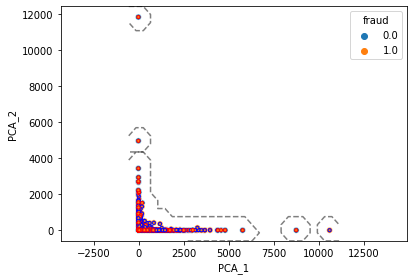

In [59]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
principal_df = pd.DataFrame(data=principal_components, columns=['PCA_1', 'PCA_2'])
principal_df.head()

final_df = pd.concat([principal_df, df[['fraud']]], axis=1)

clf = svm.OneClassSVM(nu=0.001, kernel='rbf', gamma=0.0001)
clf.fit(principal_df, df['fraud'])

# Data Visualization
plt.figure(figsize=(6, 4))
sns.scatterplot(final_df['PCA_1'], final_df['PCA_2'], hue=df['fraud'])
plot_decision_function_helper(
    principal_df.iloc, df['fraud'].iloc, clf, show_only_decision_function=False)

**SPLITING DATA**

Displaying data.
(5000, 1)
(2000, 1)


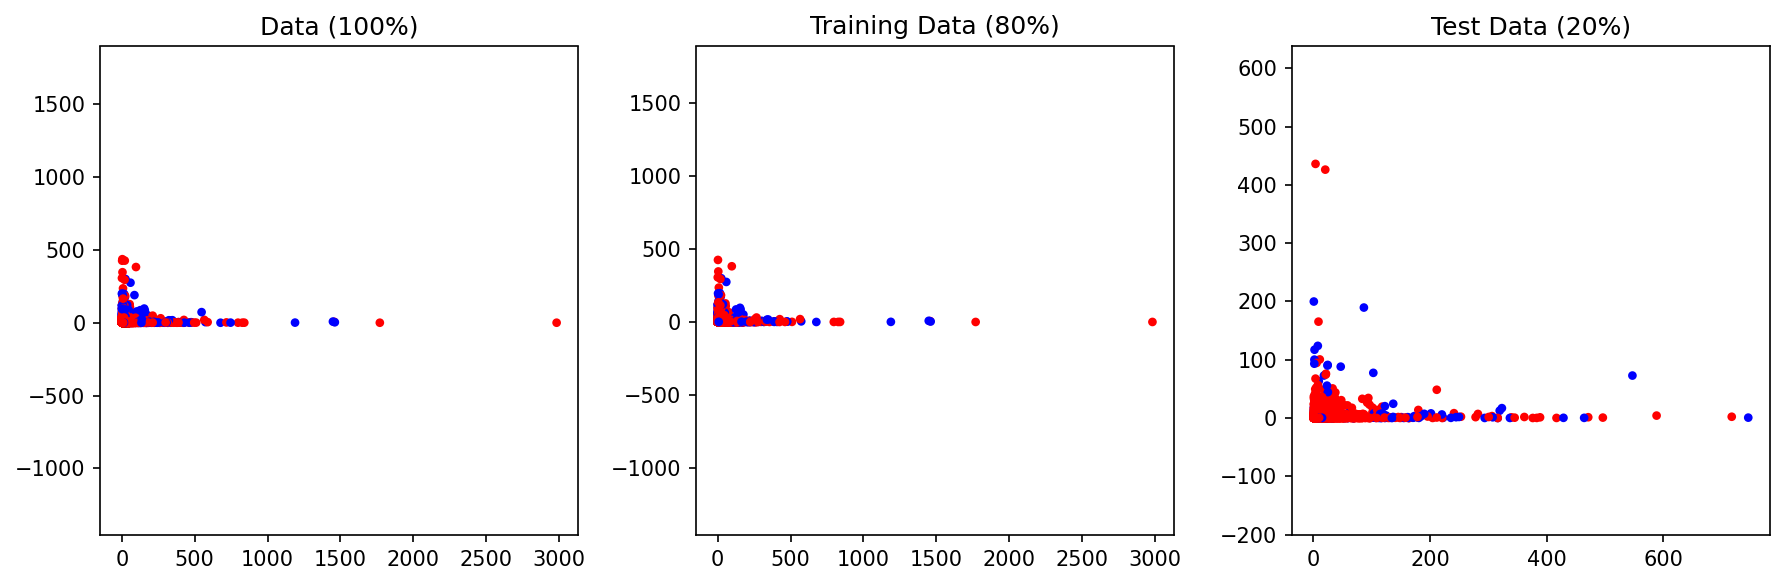

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Displaying data after SMOTE applied.
(9126, 1)
(2000, 1)


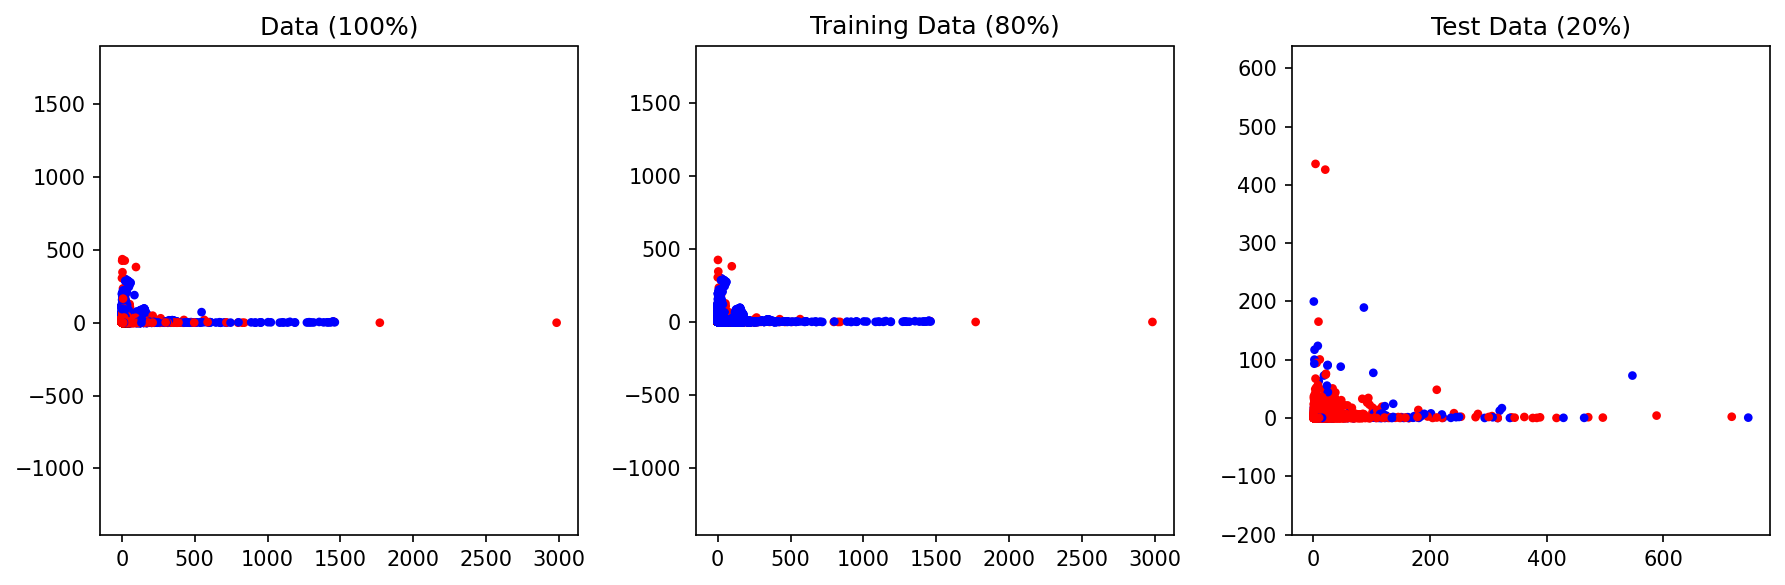

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.005, test_size=0.002, random_state=1004,
                                                    stratify=df['fraud'])

print("Displaying data.")
plot_data(X_train, y_train, X_test, y_test)

# OVERSAMPLING ENHANCES THE MODEL
smote = SMOTE(random_state=11)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train = y_train.reshape(-1,1)

print("Displaying data after SMOTE applied.")
plot_data(X_train, y_train, X_test, y_test)

## **1) SVM(OCSVM)**

**GRID SEARCH**

In [ ]:
# Grid Search
print("Performing grid search ... ")

# Parameter Grid
#param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]}
param_grid = {'nu': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.99], 'gamma': [
    1, 0.1, 0.01, 0.001, 0.00001, 10]}

# Make grid search classifier
clf_grid = GridSearchCV(svm.OneClassSVM(), param_grid,
                        verbose=1, scoring="accuracy")

# Train the classifier
clf_grid.fit(X_train, y_train)

# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

print("Displaying decision function for best estimator.")
# Plot decision function on training and test data
# plot_decision_function(X_train, y_train, X_test, y_test, clf_grid)

In [29]:
clf = svm.OneClassSVM(nu=0.001, kernel='rbf', gamma=0.0001)
clf.fit(X_train, y_train)
clf_predictions = clf.predict(X_test)

In [30]:
y_pred_test = clf.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test = y_pred_test.replace({-1: 1, 1: 0})
y_pred_test

,0
0,0
1,0
2,0
3,0
4,0
...,...
1995,0
1996,0
1997,0
1998,0


auc_keras:0.7917716204869857
Precision score: 0.06
Recall score: 0.67
F1 score: 0.11
Average precision-recall score: 0.04
FRR: 0.00274
FAR: 0.94286


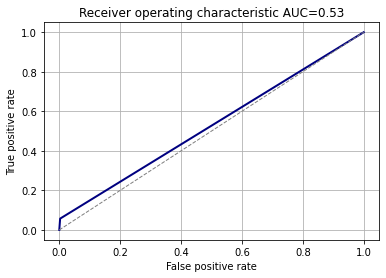

In [101]:
get_all_metrics_(y_pred_test, y_test)
plot_roc_curve(y_test, y_pred_test, size=None)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
fnr = 1-tpr

print('FRR: {0:0.5f}'.format(fpr[1]))
print('FAR: {0:0.5f}'.format(fnr[1]))


Text(0.5, 15.0, 'Predicted')

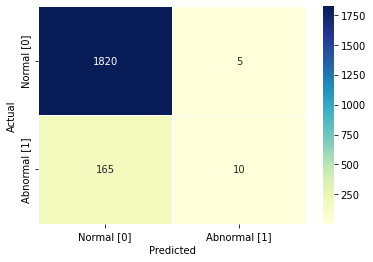

In [89]:
con_mat = confusion_matrix(y_test, y_pred_test)
sns.heatmap(pd.DataFrame(con_mat, columns=['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

## **2) SVDD(Suport Vector Data Description)**

In [60]:
from BaseSVDD import BaseSVDD


In [102]:
svdd=BaseSVDD(C=0.001, gamma=0.0001, kernel='rbf',display='on')
X_train_forSVDD = X_train



In [ ]:
svdd.fit(X_train_forSVDD)
